### 3.1 Import files

Re-run accuracy table (fit on test set). 

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
import sklearn.feature_extraction.text 
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, mean_squared_error, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [2]:
df = pd.read_csv('../project_3/CSV files/final_df.csv')

In [3]:
df.drop(columns ='Unnamed: 0', axis=1, inplace=True) #to drop unnamed column


In [4]:
print(df.shape)
df.info()

(19912, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19912 entries, 0 to 19911
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    19912 non-null  int64 
 1   clean_title  19892 non-null  object
dtypes: int64(1), object(1)
memory usage: 311.2+ KB


- I noticed when the new_df got saved in the previous python notebook, the 'nan' values under the clean_title gets recognized. Time to clean it!

In [5]:
bool_series = pd.isnull(df["clean_title"]) 

In [6]:
df[bool_series] #shows nan values under "clean_title" column

,subreddit,clean_title
1812,1,NaN
2790,1,NaN
2935,1,NaN
3719,1,NaN
5906,1,NaN
7504,1,NaN
9052,1,NaN
10670,0,NaN
11315,0,NaN
12534,0,NaN


In [7]:
df.dropna(subset = ["clean_title"], inplace=True)

In [8]:
df.isna().sum()

subreddit      0
clean_title    0
dtype: int64

In [9]:
print(df.info()) #no more isna 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19892 entries, 0 to 19911
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subreddit    19892 non-null  int64 
 1   clean_title  19892 non-null  object
dtypes: int64(1), object(1)
memory usage: 466.2+ KB
None


### Setting up data for modelling

In [10]:
X = df['clean_title']
y = df['subreddit']

In [11]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [12]:
X_train.iloc[0]

'love cute littl cat'

### Running a simple CountVectorizer & Explore hyperparameters

In [13]:
# CountVectorizer, stop_words='english', max_features=100
cvec = CountVectorizer(stop_words='english', max_features=100)
cvec.fit(X_train)
X_train = cvec.transform(X_train)

X_train_df = pd.DataFrame(X_train.toarray(),columns=cvec.get_feature_names())

In [14]:
X_train_df.sum().sort_values(ascending=False).head(20)

dog       4298
cat       2378
help       783
old        574
like       518
love       459
need       452
good       451
puppi      441
new        419
year       377
look       373
littl      362
kitten     353
breed      341
advic      319
food       308
know       308
anyon      307
eat        305
dtype: int64

- Apart from cats and dogs, the word 'help' seems to appear a lot. Perhaps dogs and cats owners use Reddit as a help forum?
- Based on the word 'love', perhaps alot of owners really love their pets. 
- 'Breed' might be an topic of interest amongst pet owners
- The words "like" and "love" all appeared here, which can be used maybe as an indicator of either dog or cat's popularity. We may try max_df and min_df this time to rule out words that appear in too many documents.

In [15]:
#Understand which words belong udner which subreddit
n_words = 40
words = list(X_train_df.sum().sort_values(ascending=False)[:n_words].index)
X_train_df['subreddit'] = y_train.values

In [16]:
X_train_df.groupby('subreddit')

In [17]:
X_train_df_small = X_train_df.groupby('subreddit').sum()[words]
X_train_df_small.head().T

subreddit,0,1
dog,55,4243
cat,2324,54
help,197,586
old,261,313
like,352,166
love,390,69
need,156,296
good,227,224
puppi,2,439
new,238,181


- It makes sense that the top frequency of the word 'dog' is in the subreddit 'Dogs' (Labelled 1). This is also sensible for the subreddit 'Cats'.
- Surprisingly, alot of subredditors in the "Dogs" subreddit seem to use the word 'help'. Perhaps more dog owners/lovers use Reddit for help on dog-related issues. This also makes sense as the word 'advic' is most prominent in the 'Dog' subreddit.
- The word 'love" seem to be a regular words amonfgst Redditors who frequent 'Cat' subreddit. 
- The words 'littl', 'look', 'babi' and 'cute' seems to be more in the 'cat' redditors. Do cat owners love cute kittens/cute things? Perhaps we could use bi-grams to check if these words are associated.

### Re-running CountVectorizer & with new hyperparameters

In [18]:
# Redefine X and resplit data
X = df['clean_title']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

# CountVectorizer, stop_words='english', max_features=100, 
# max_df=.95, min_df=.05, ngram_range(1,3)
cvec = CountVectorizer(stop_words='english', max_df=.95, min_df=.05, 
                       max_features=100, ngram_range=(1,3))
cvec.fit(X_train)
X_train = cvec.transform(X_train)

X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=cvec.get_feature_names())

In [19]:
X_train_df.sum().sort_values(ascending=False).head(20)

dog     4274
cat     2347
help     808
dtype: int64

- Apparently this dataset does not contain many words that appear either not extremely frequently or not extremely sparsely across both subreddits. Might mean that most words are unique to the subreddit? Or may indicate that there won't be many strong predictors for subreddit? 

### Running Tfidf Vectorizer & with new hyperparameters

In [20]:
# Redefine X and resplit data
X =  df['clean_title']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

# Parameters: Tfidf, stop_words='english', max_features=200, ngram_range=(1,2)
tvec = TfidfVectorizer(stop_words='english', max_features=200, ngram_range=(1,2))
tvec.fit(X_train)
X_train = tvec.transform(X_train)

X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=tvec.get_feature_names())

In [21]:
X_train_df.sum().sort_values(ascending=False).head(20)

dog       1641.636080
cat       1072.359520
help       385.708781
like       257.208551
puppi      257.034876
love       246.393809
good       226.649298
new        218.764214
old        215.597635
need       215.540067
look       204.926809
littl      190.962379
advic      182.434549
kitten     176.723004
breed      173.867245
think      165.114292
eat        161.729853
food       160.377984
know       160.069444
day        158.312737
dtype: float64

- Try Tfidf one more time with ngram_range=(1,4).

In [22]:
# Redefine X and resplit data
X = df['clean_title']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

# Parameters: Tfidf, stop_words='english', max_features=200, ngram_range=(1,4)
tvec = TfidfVectorizer(stop_words='english', max_features=200, ngram_range=(1,4))
tvec.fit(X_train)
X_train = tvec.transform(X_train)

X_train_df = pd.DataFrame(X_train.toarray(),
                          columns=tvec.get_feature_names())

In [23]:
X_train_df.sum().sort_values(ascending=False).head(20)

dog       1641.636080
cat       1072.359520
help       385.708781
like       257.208551
puppi      257.034876
love       246.393809
good       226.649298
new        218.764214
old        215.597635
need       215.540067
look       204.926809
littl      190.962379
advic      182.434549
kitten     176.723004
breed      173.867245
think      165.114292
eat        161.729853
food       160.377984
know       160.069444
day        158.312737
dtype: float64

- No difference if we changd the ngram range.

## Baseline accuracy

In [24]:
# Check what we need to check in a classification problem. The value counts are quite balanced.
y_test.value_counts(normalize=True)

1    0.505864
0    0.494136
Name: subreddit, dtype: float64

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

- We have a baseline accuracy of ~50.1% because our majority class ('subreddit' == 1 AKA 'dog') comprises ~50.1% of the data. Thus, if we predicted that all posts came from the dogs subreddit, we would be accurate ~50.1% of the time

### Modeling Using the `Random Forest Classifier  + CountVectorizer`

In [26]:
# Set up pipeline
pipe_rf_c = Pipeline([
    ('cvec', CountVectorizer(stop_words='english', max_features=500, ngram_range=(1,2))),
    ('rf', RandomForestClassifier())
])

# Set up pipeline parameters
pipe_rf_c_params = {
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 5, 6], 
    'rf__max_features': ['auto', 'log2'],
    'rf__min_samples_split': [2, 50]}

In [27]:
# Set up a gridsearch
gs_rf_c = GridSearchCV(pipe_rf_c, pipe_rf_c_params, cv=5)


In [28]:
# Fit the gridsearch
gs_rf_c.fit(X_test, y_test);

In [29]:
# Find best score
gs_rf_c.best_score_

0.8956587966488957

In [30]:
# Find best parameters
gs_rf_c.best_params_

{'rf__max_depth': None,
 'rf__max_features': 'log2',
 'rf__min_samples_split': 50,
 'rf__n_estimators': 100}

### Modeling Using the `Random Forest Classifier  + TFIDF Vectorizer`

In [31]:
# Set up pipeline
pipe_rf_t = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english', max_features=500, ngram_range=(1,2))),
    ('rf', RandomForestClassifier())
])

# Set up pipeline parameters
pipe_rf_t_params = {
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [None, 5, 6], 
    'rf__max_features': ['auto', 'log2'],
    'rf__min_samples_split': [2, 50, 100]
}

In [32]:
# Set up a gridsearch
gs_rf_t = GridSearchCV(pipe_rf_t, pipe_rf_t_params, cv=5, verbose=1)



In [33]:
# Fit the gridsearch
gs_rf_t.fit(X_test, y_test);

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [34]:
# Find best score
gs_rf_t.best_score_

0.8958111195734958

In [35]:
# Find best parameters
gs_rf_t.best_params_

{'rf__max_depth': None,
 'rf__max_features': 'log2',
 'rf__min_samples_split': 50,
 'rf__n_estimators': 200}

### Modeling Using the `Naive Bayes  + CountVectorizer`

In [36]:
# Setting a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)
# Set up pipeline
pipe_nb_c = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())])

In [37]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [38]:
# Instantiate GridSearchCV.

gs_nb_c = GridSearchCV(pipe_nb_c, 
                  param_grid=pipe_params, 
                  cv=5) # 5-fold cross-validation.

In [39]:
# Fit GridSearch to training data.
gs_nb_c.fit(X_test, y_test)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec',
                                        CountVectorizer(stop_words='english')),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [40]:
# What's the best score?
print(gs_nb_c.best_score_)

0.8962680883472963


In [41]:
# Find best parameters
gs_nb_c.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

### Modeling Using the `Naive Bayes  + TFIDF Vectorizer`

In [42]:
# Set up pipeline
pipe_nb_t = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

In [43]:
# Set up pipeline parameters
params_grid = {
    'nb__alpha': [1.0], 
   'nb__fit_prior': [True, False]
}

In [44]:
# Set up a gridsearch
gs_nb_t = GridSearchCV(pipe_nb_t,param_grid=params_grid
                       , cv=5,verbose=1)

In [45]:
# Fit the gridsearch
gs_nb_t.fit(X_test, y_test);

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [46]:
# What's the best score?
print(gs_nb_t.best_score_)

0.8865194211728866


In [47]:
# Find best parameters
gs_nb_t.best_params_

{'nb__alpha': 1.0, 'nb__fit_prior': False}

### Modeling Using the `Logistic Regression  + Count Vectorizer`

In [48]:
# Set up pipeline
pipe_lr_c = Pipeline([
    ('cvec', CountVectorizer(stop_words='english', ngram_range=(1,2))),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=5000))
])


In [49]:
# Set up pipeline params
pipe_lr_c_params = {
    'cvec__max_features': [200, 500],
}

In [50]:
# Set up a gridsearch
gs_lr_c = GridSearchCV(pipe_lr_c, pipe_lr_c_params, cv=5, verbose=1)


In [51]:

# Fit the gridsearch
gs_lr_c.fit(X_test, y_test);

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [52]:
# Find best score
gs_lr_c.best_score_

0.8947448591012946

In [53]:
# Find best parameters
gs_lr_c.best_params_

{'cvec__max_features': 500}

### Modeling Using the `Logistic Regression  + Tfidf Vectorizer`

In [54]:
# Set up pipeline
pipe_lr_t = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english', ngram_range=(1,2))),
    ('lr', LogisticRegression(solver='lbfgs', max_iter=5000))
])


In [55]:

# Set up pipeline params
pipe_lr_t_params = {
    'tvec__max_features': [200, 500],
}

In [56]:
# Set up a gridsearch
gs_lr_t = GridSearchCV(pipe_lr_t, pipe_lr_t_params, cv=5, verbose=1)


In [57]:
# Fit the gridsearch
gs_lr_t.fit(X_test, y_test);

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [58]:
# Find best score
gs_lr_t.best_score_

0.8971820258948972

In [59]:
# Find best parameters
gs_lr_t.best_params_

{'tvec__max_features': 500}

### Compare models

In [60]:
# Generate a dataframe of model & accuracy score
list_of_models = [gs_rf_c, gs_rf_t, 
                  gs_nb_c, gs_nb_t,
                  gs_lr_c, gs_lr_t]

# Create an empty list for each model's dictionary
models = []

for mod in list_of_models:
    # mod.best_score_
    model = {}
    model['type'] = str(list(mod.estimator.named_steps.keys()))
    model['accuracy'] = mod.best_score_
    models.append(model)

# Append baseline for comparison
baseline = {}
baseline['type'] = 'baseline'
baseline['accuracy'] = y_train.value_counts(normalize=True)[1]
models.append(baseline)

models_df = pd.DataFrame(models)
models_df.head(6)

,type,accuracy
0,"['cvec', 'rf']",0.895659
1,"['tvec', 'rf']",0.895811
2,"['cvec', 'nb']",0.896268
3,"['tvec', 'nb']",0.886519
4,"['cvec', 'lr']",0.894745
5,"['tvec', 'lr']",0.897182


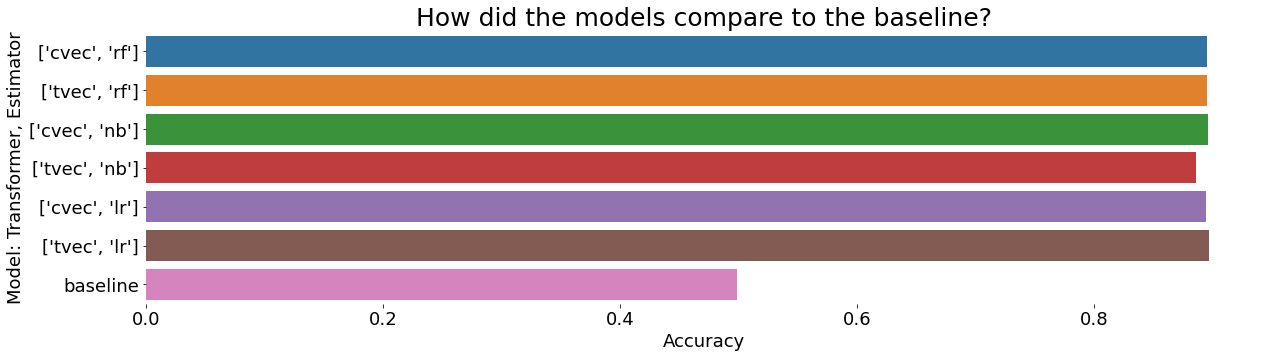

In [62]:
plt.figure(figsize=(20,5))
sns.barplot(data=models_df, x='accuracy', y='type')
plt.xlabel('Accuracy', size=18)
plt.ylabel('Model: Transformer, Estimator', size=18)
plt.yticks(size=18)
plt.xticks(size=18)
plt.title('How did the models compare to the baseline?', size=25)
sns.despine(left=True, bottom=True);

- Naive Bayes with a CountVectorizer received the highest accuracy rating overall of models run, with an accuracy score of ~92.3% on train data. This is followed by Random Forest with a CountVectorizer at ~90.1%, logistic regression with TFIDF Vectorizer at ~ 90.1%, Random Forest with a TFIDF Vectorizer at ~90.0% and Naive Bayes with a TFIDF Vectorizer at ~89.4%.
- As we can see, all models (with different transformers) received fairly similar scores on training data. We got the best parameters for each model that yielded these scores and will instantitate and test on test data below to get a more comprehensive view of the models' effectiveness in predicting subreddit classification of posts.
- We will evaluate 2 models - Logistic Regression with TFIDF Vectorizer and Random Forest Classifier with TFIDF Vectorizer - and pick the best. I decided not to take Naive Bayes Model (even though it performs the best) because it assumes all the features are independent of one another (which in this business context, I do not think is correct to assume that). 